In [16]:
# !pip install --ignore-installed llvmlite
# pip install tsfeatures

In [18]:
# from tsfeatures import tsfeatures as tf
# from tsfeatures import acf_features

# acf = acf_features(amp)
# print(acf)

{'x_acf1': 0.9999582361782643, 'x_acf10': 9.994284969266813, 'diff1_acf1': 0.04133651174934224, 'diff1_acf10': 0.016496135313006394, 'diff2_acf1': -0.4999198686030941, 'diff2_acf10': 0.24991987504080515}


In [56]:
import numpy as np

file_path = 'data/40secondlookrightlaps.csv'

with open(file_path, 'r') as file:
    csv_content = file.readlines()

Time = [float(line.split(',')[0]) for line in csv_content]
amp = [float(line.split(',')[1]) for line in csv_content]

time = np.array(Time)
amp_array = np.array(amp)

time[:5], amp[:5]

(array([0.        , 0.00010002, 0.00020004, 0.00030006, 0.00040008]),
 [512.2624392830535,
  512.2552571016865,
  512.2481099818019,
  512.2410032117142,
  512.2339420623805])

Test statistics: [4. 4. 4. ... 3. 3. 2.]


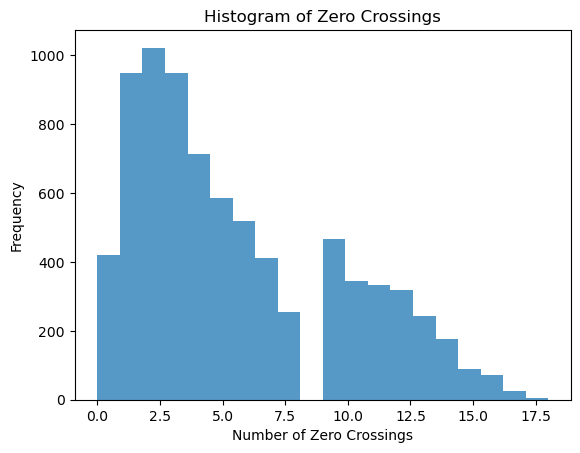

Predicted events: [ True  True  True ...  True  True  True]
{'num_event': 10, 'predictedEventTimes': array([False, False, False, ..., False, False, False]), 'predictedInterval': array([[ 0.25      ,  2.61547901],
       [ 4.56087295,  6.51626892],
       [ 7.0213712 ,  8.02157374],
       [10.25202541, 10.62710136],
       [11.23722491, 14.35285583],
       [16.0331961 , 18.03360118],
       [18.53870346, 25.86018606],
       [26.36528835, 30.86119877],
       [34.09685399, 35.9122216 ],
       [36.59235933, 39.74799834]])}


In [68]:
import matplotlib.pyplot as plt

def eye_movement_ZC(Y, time, windowSize=0.5, thresholdEvents=7, downSampleRate=50):
    
    time_max = time.max()
    ind = np.where(time <= time_max - windowSize)[0][-1]  
    ind = np.arange(0, ind + 1, downSampleRate)

    timeMiddle = time[ind] + windowSize / 2
    testStat = np.zeros(len(ind))
    
    Y_mean = np.mean(Y)
    Y = Y - Y_mean
    
    for i, idx in enumerate(ind):
        window_mask = (time >= time[idx]) & (time < time[idx] + windowSize)
        Y_subset = Y[window_mask]

        zero_crossings = np.sum(np.diff(np.sign(Y_subset)) != 0)
        testStat[i] = zero_crossings

    predictedEvent = testStat < thresholdEvents
    eventTimes = timeMiddle[predictedEvent]
    
    print("Test statistics:", testStat)
    plt.hist(testStat, bins=20, alpha=0.75)
    plt.title('Histogram of Zero Crossings')
    plt.xlabel('Number of Zero Crossings')
    plt.ylabel('Frequency')
    plt.show()
    print("Predicted events:", predictedEvent)
    
    
    gaps = np.where(np.diff(eventTimes) > windowSize)[0]
    event_time_interval = [eventTimes[0]]
    
    for gap in gaps:
        event_time_interval.extend([eventTimes[gap], eventTimes[gap+1]])
        
    event_time_interval.append(eventTimes[-1])
    event_time_interval = np.array(event_time_interval).reshape(-1, 2)
    
    predictedEventTimes = np.zeros(len(Y), dtype=bool)
    for start, end in event_time_interval:
        predictedEventTimes[(time >= start) & (time <= end)] = True
        
    num_event = len(gaps) + 1

    
    return {
        'num_event': num_event, 
        'predictedEventTimes': predictedEventTimes,
        'predictedInterval': event_time_interval
    }

testSta = []
eye_movement_results = eye_movement_ZC(amp, time)
print(eye_movement_results)




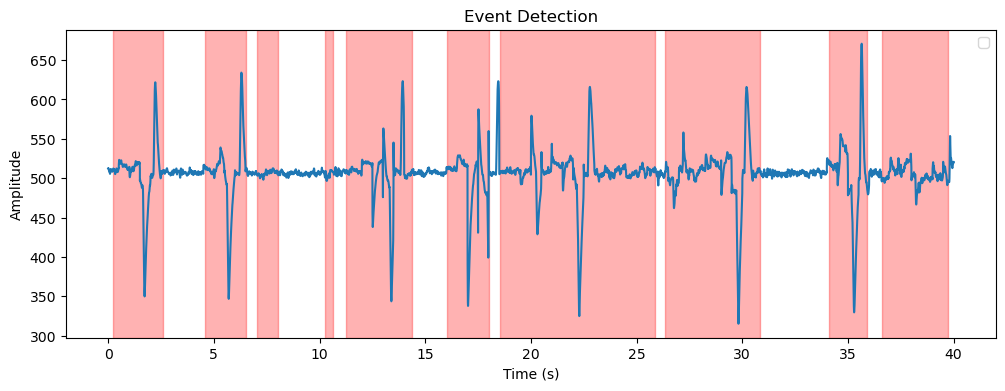

In [69]:
plt.figure(figsize=(12, 4))
plt.plot(time, amp)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Event Detection')

event_intervals = eye_movement_results['predictedInterval']
for interval in event_intervals:
    start, end = interval

    plt.axvspan(start, end, color='red', alpha=0.3)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()


In [74]:
def extract_laps(laps_data, name):
    lines = laps_data.strip().split("\n")
    laps = []
    found = False
    for line in lines:
        line = line.strip()
        if not line:
            pass
        elif not line.replace(".", "").isnumeric():
            if found:
                break
            if name == line:
                found = True
        elif found:
            laps.append(float(line))
    laps = np.cumsum(np.array(laps))
    return laps

laps_txt_path = 'data/laps.txt'
with open(laps_txt_path, 'r') as file:
    laps_file_content = file.read()

laps = extract_laps(laps_file_content, '40secondlookrightlaps')
laps


array([ 4.65,  9.22, 16.84, 21.53, 25.87, 33.12, 40.39])

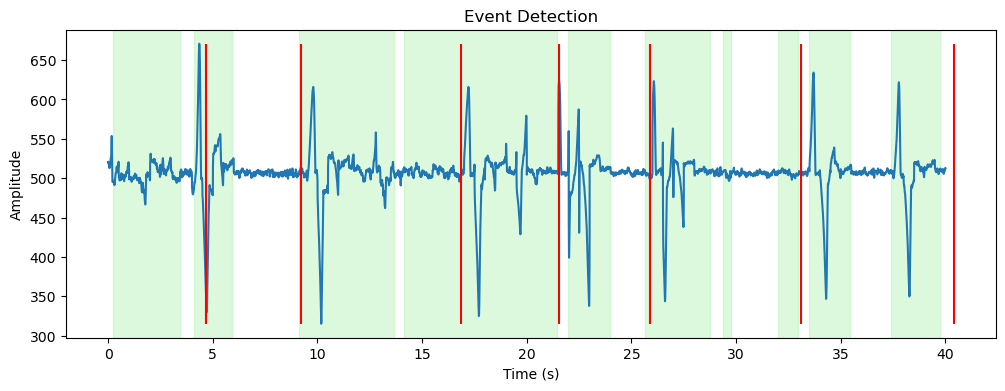

In [81]:
def plot_data(time, amp, laps=None, event_intervals=None, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(time, amp)
    if laps is not None:
        ax.vlines(laps, np.min(amp), np.max(amp), color="red")
    if event_intervals is not None:
        for start, end in event_intervals:
            ax.axvspan(start, end, color='lightgreen', alpha=0.3)

amp_reversed = amp[::-1]

max_time = np.max(time)
reversed_intervals = [(max_time - end, max_time - start) for start, end in eye_movement_results['predictedInterval']]
reversed_intervals.sort()

plt.figure(figsize=(12, 4))
plot_data(time, amp_reversed, laps=laps, event_intervals=reversed_intervals)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Event Detection')
plt.show()